# XGBoost

In [1]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets xgboost
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade xgboost


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb
import torch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import zipfile
import os

from panelsplit.cross_validation import PanelSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

import random

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

100


c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


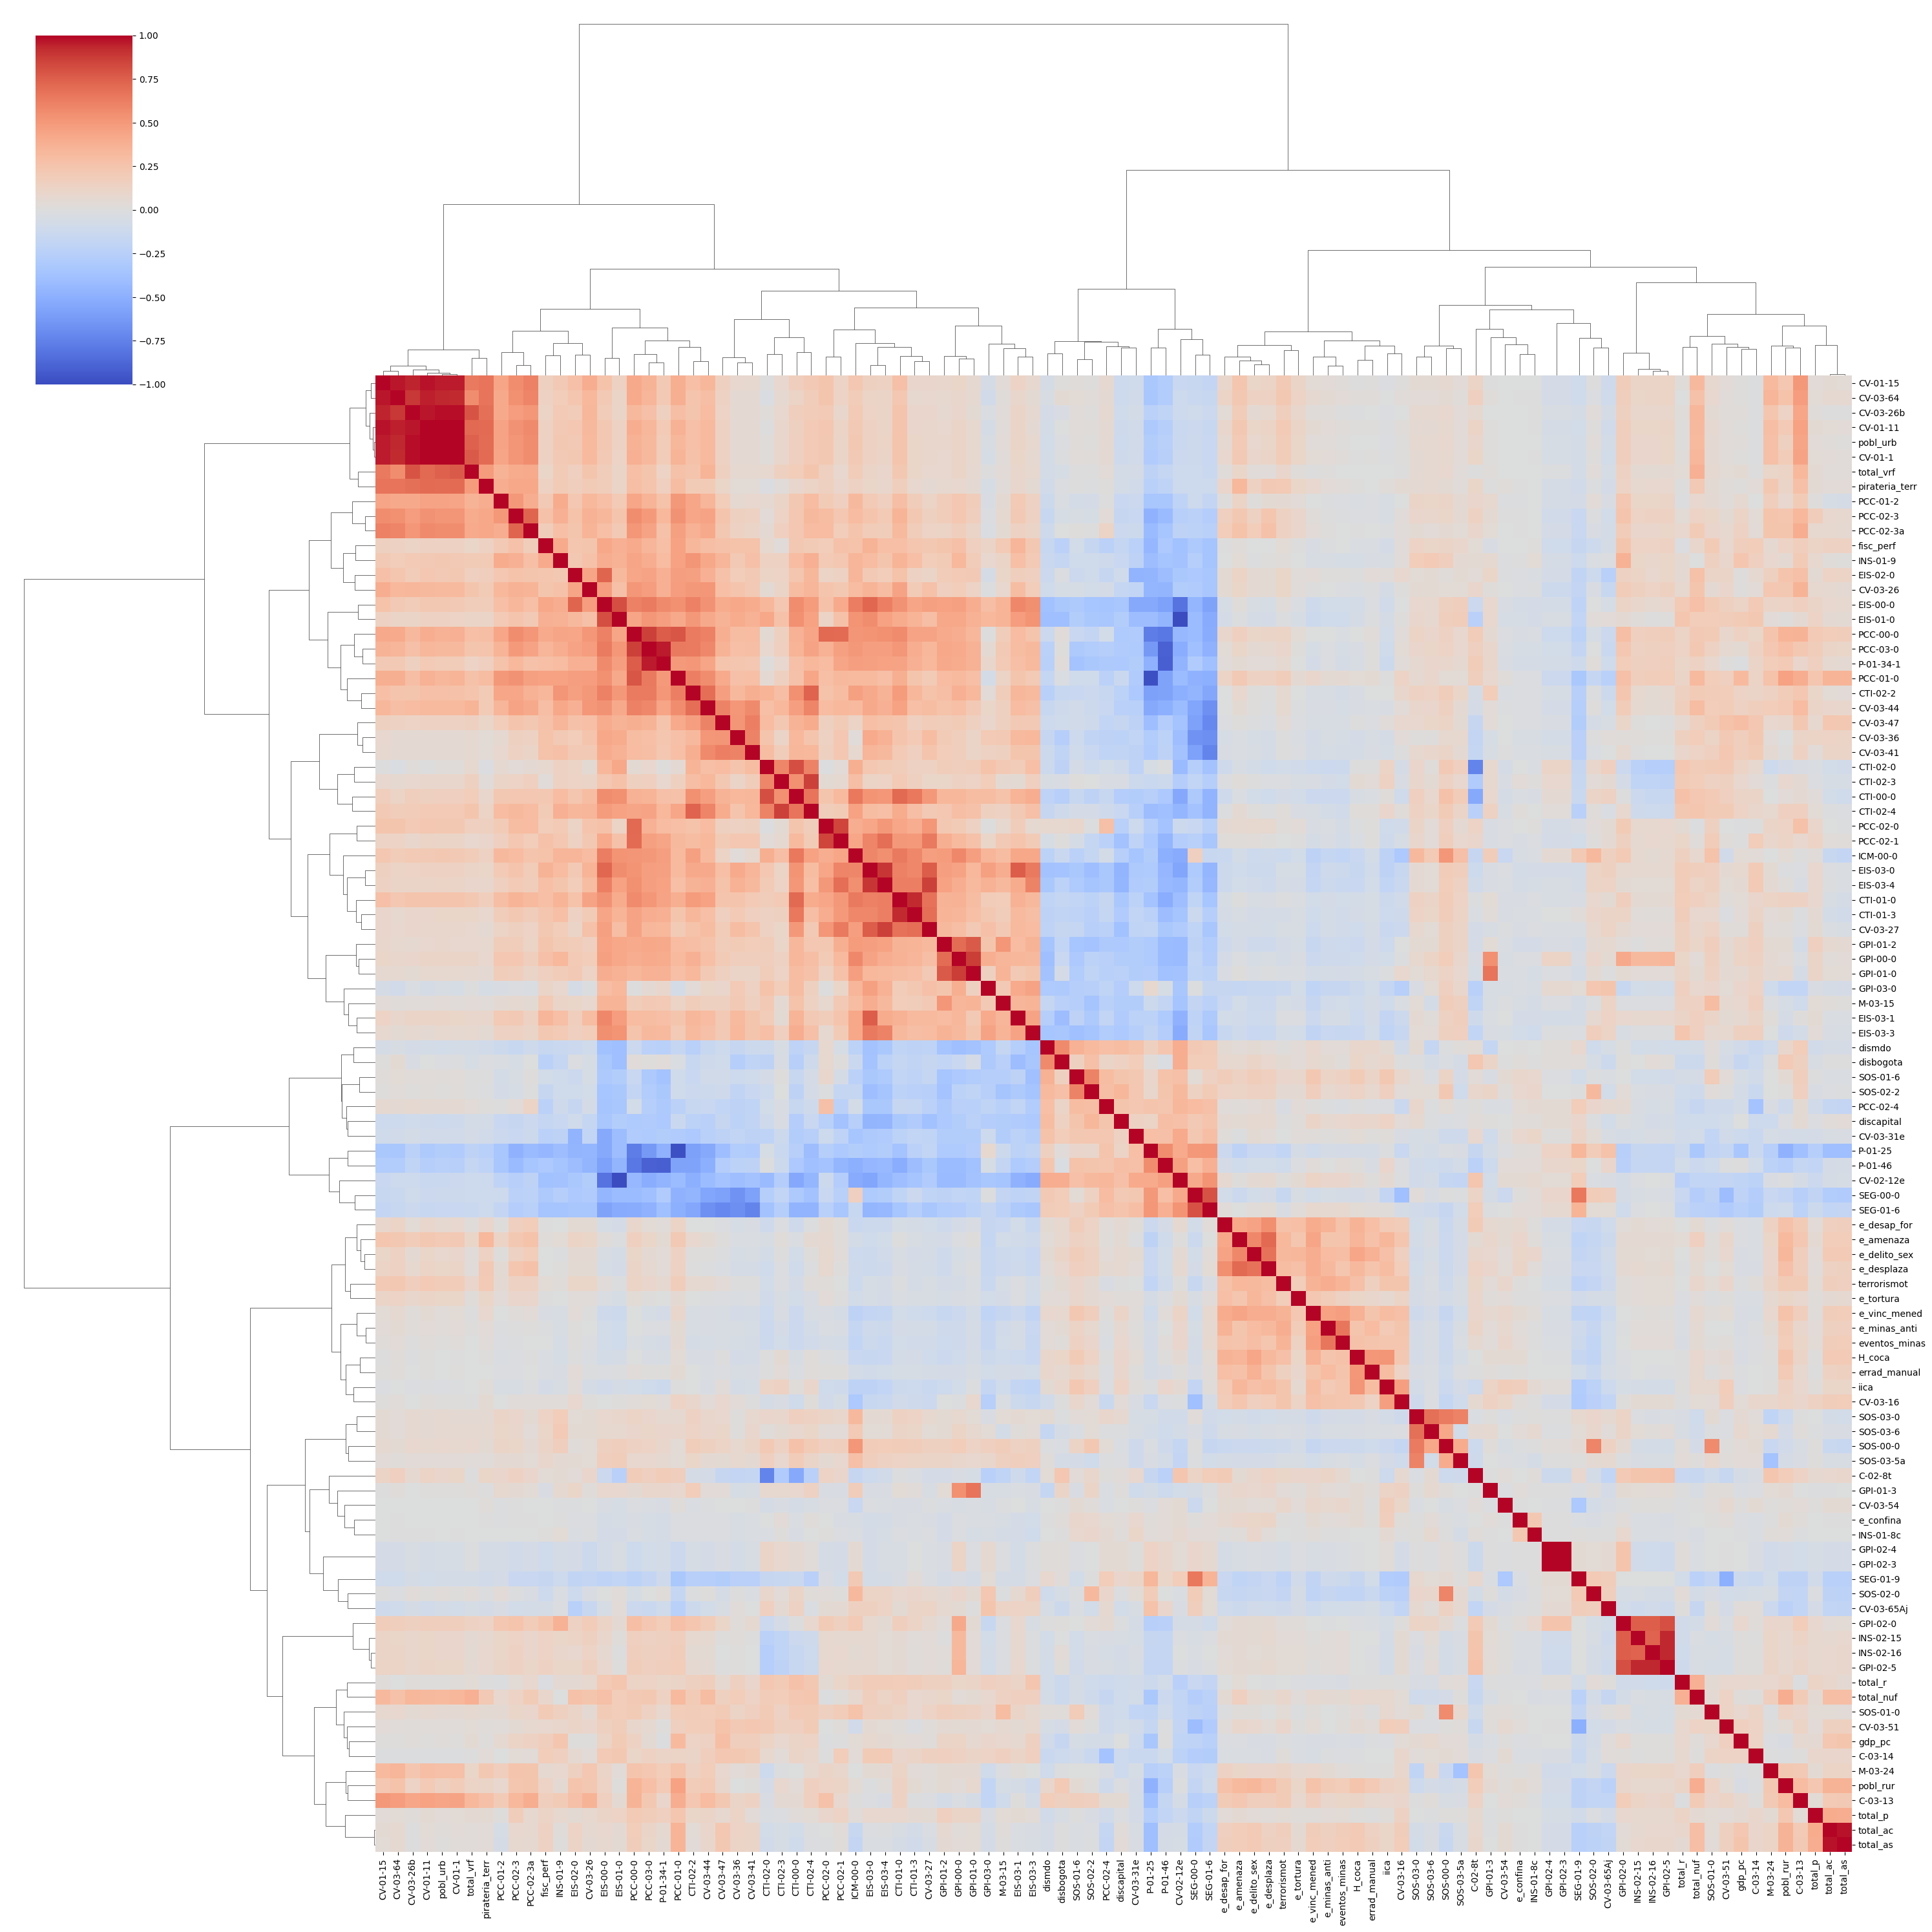

In [53]:
#Getting rid of redundant columns

X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
print(len(X1.columns))
# Compute the correlation matrix
corr_matrix = X1.corr()

# Plot the correlation matrix
sns.clustermap(corr_matrix, 
               method='ward',  # or 'complete', 'average'
               cmap='coolwarm',
               figsize=(30, 30))
plt.show()

71


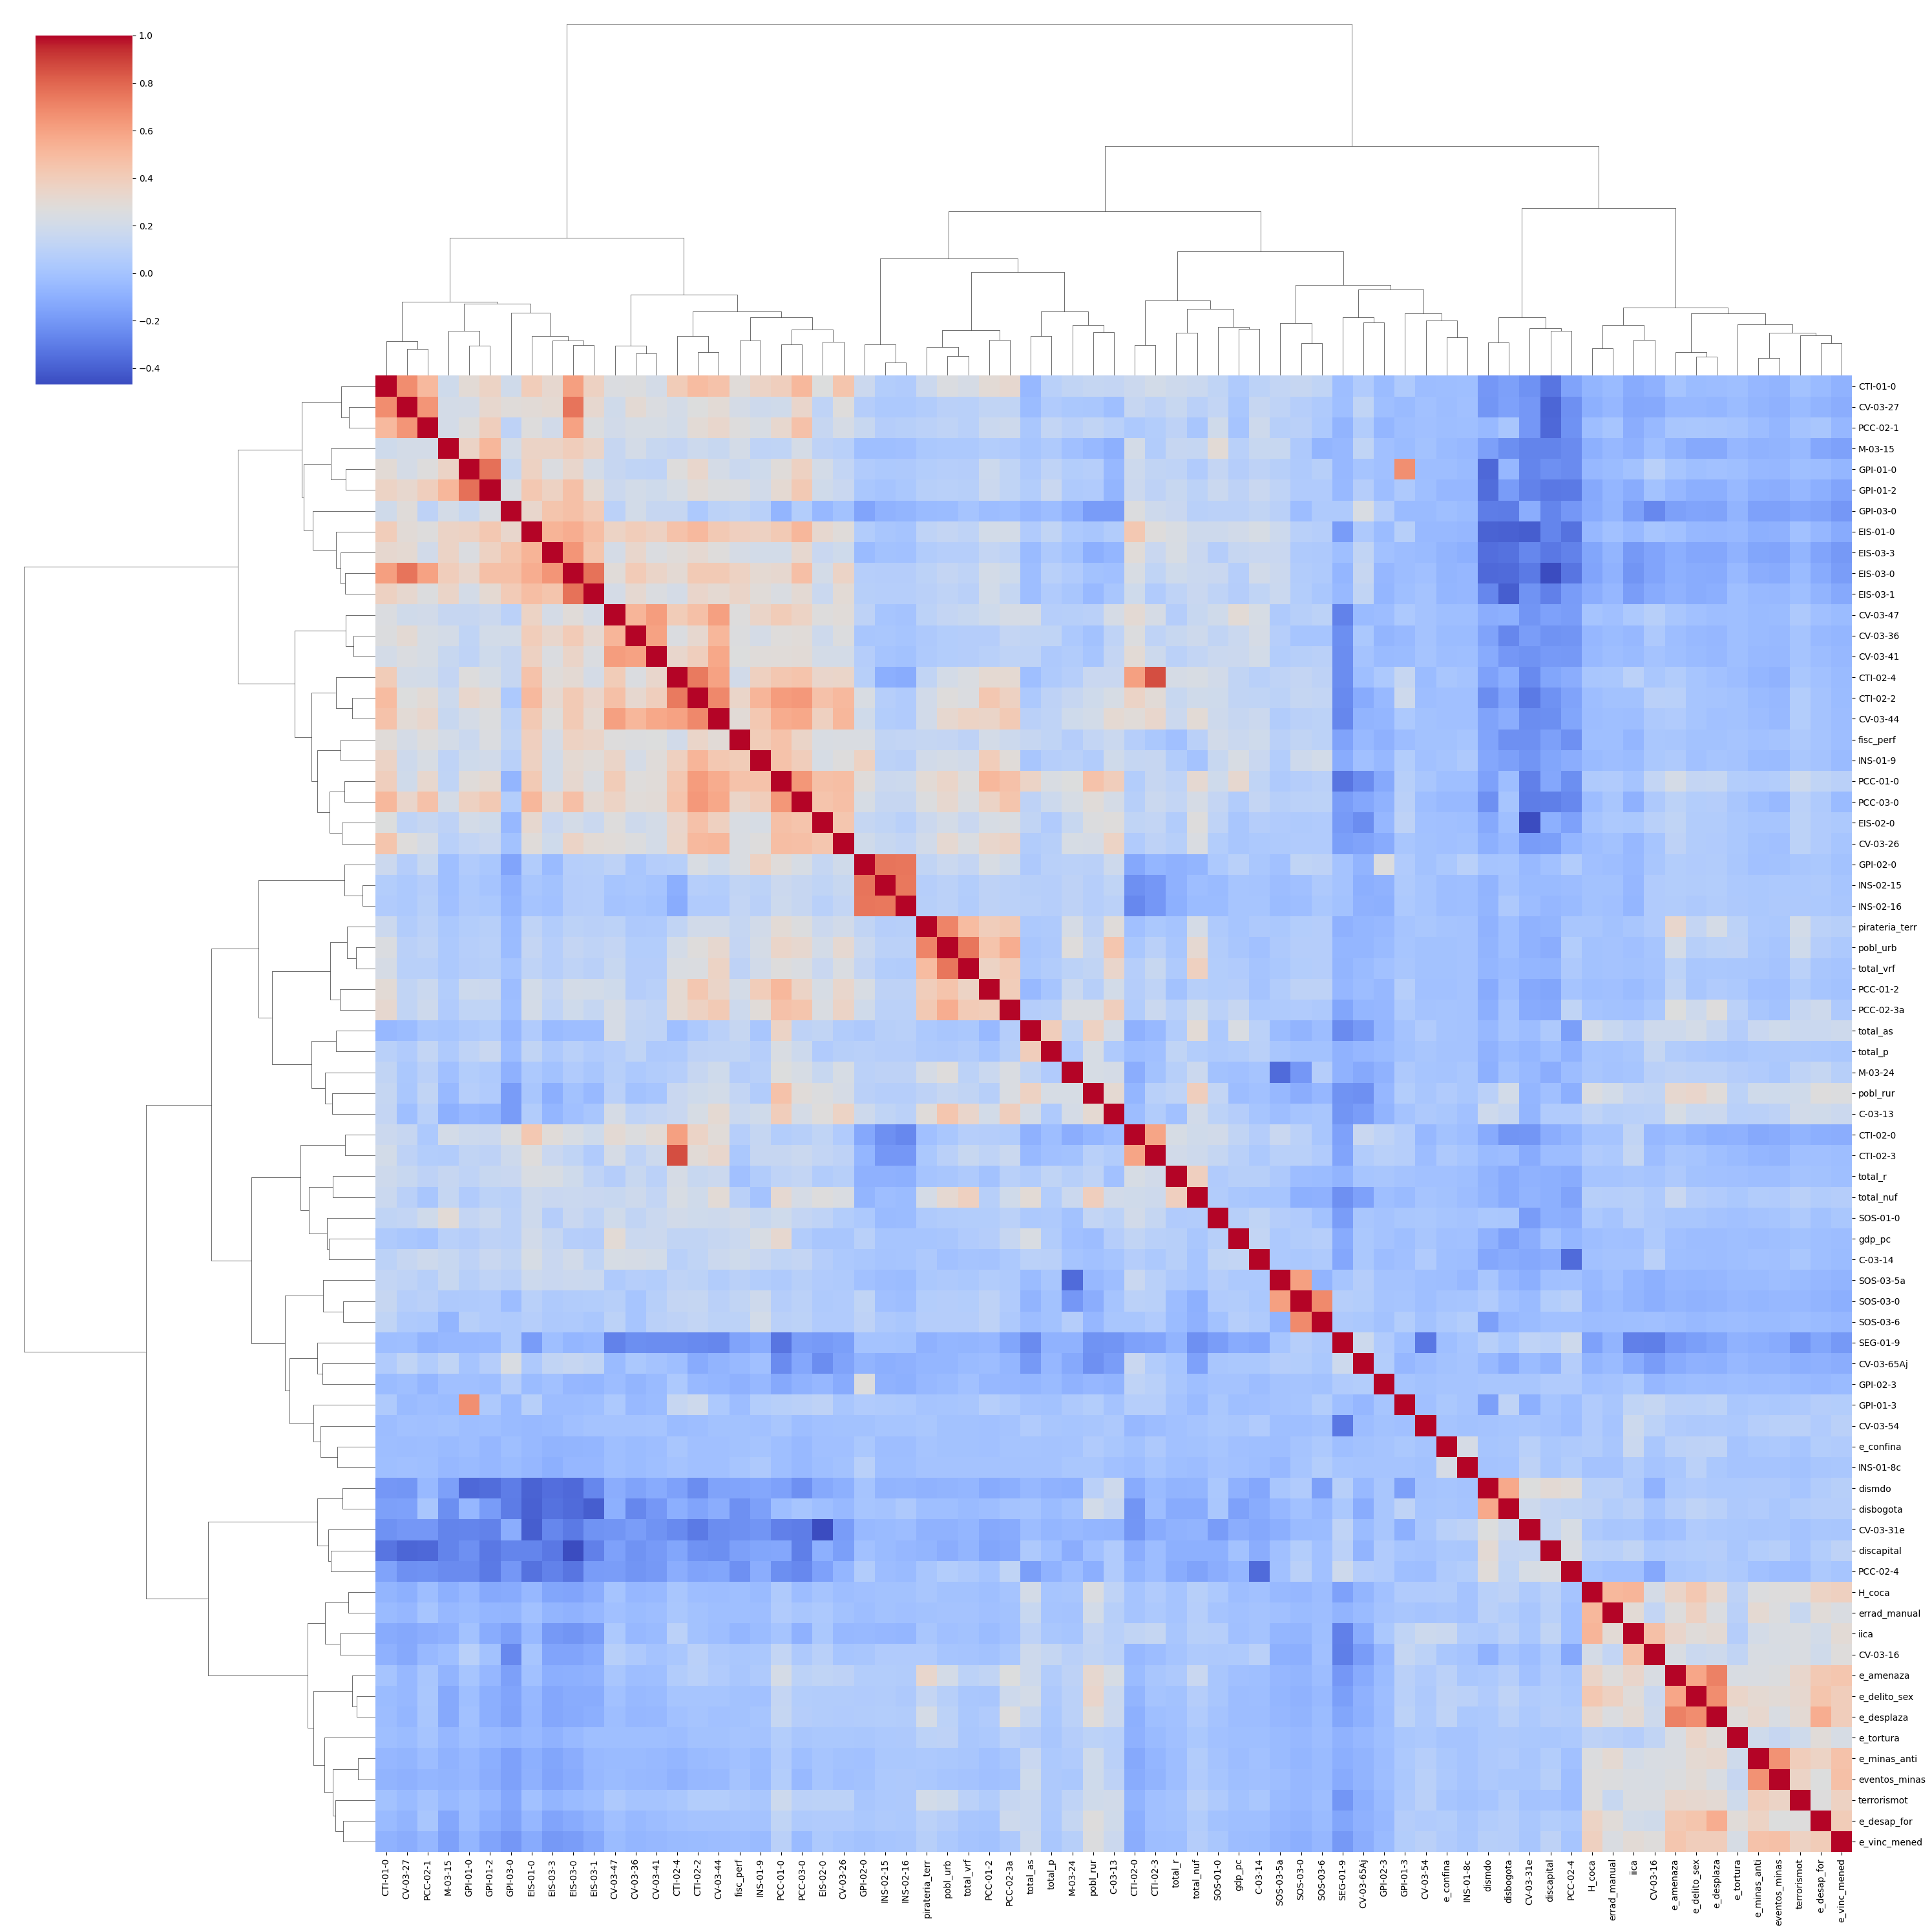

In [54]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])

# Normalize output
scaler = StandardScaler()
# y = scaler.fit_transform(y.values.reshape(-1, 1))

# X final
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 
print(len(X1.columns))
# Keep feature names
original_feature_names = list(X1.columns) 

# Plot the new correlation matrix
corr_matrix = X1.corr()
sns.clustermap(corr_matrix, 
               method='ward',  # or 'complete', 'average'
               cmap='coolwarm',
               figsize=(30, 30))
plt.show()

In [ ]:
# 🔹 Set Device for XGBoost (CPU or GPU)
from sklearn.metrics import mean_absolute_error


device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# 🔹 Define XGBoost Model Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 0.01,  # L1 Regularization
    "lambda": 0.1,  # L2 Regularization
    "device": "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store Results for Cross-Validation
cv_results = []

for train_idx, test_idx in panel_split.split(X1):
    # Split dataset into Train & Test
    X_train, X_test = X1[train_idx], X1[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 🔹 Train XGBoost Model
    xgb_model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds=50)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # 🔹 Get Predictions
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # 🔹 Compute Performance Metrics
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # 🔹 Store Results
    cv_results.append({"MSE": mse, "RMSE": rmse, "MAE": mae, "R2_train": r2_train, "R2_test": r2_test})

# 🔹 Compute Averages Across CV Splits
avg_results = {metric: np.mean([fold[metric] for fold in cv_results]) for metric in cv_results[0].keys()}

# 🔹 Print Results
print(f"✅ XGBoost with PanelSplit Results:")
print(f"📊 Avg MSE: {avg_results['MSE']:.4f}")
print(f"📊 Avg RMSE: {avg_results['RMSE']:.4f}")
print(f"📊 Avg MAE: {avg_results['MAE']:.4f}")
print(f"📊 Avg R² (Train): {avg_results['R2_train']:.4f}")
print(f"📊 Avg R² (Test): {avg_results['R2_test']:.4f}")

✅ XGBoost with PanelSplit Results:
📊 Avg MSE: 0.0041
📊 Avg RMSE: 0.0635
📊 Avg MAE: 0.0332
📊 Avg R² (Train): 0.9570
📊 Avg R² (Test): 0.6674


In [ ]:
# Set seed for reproducibility
seed_value = 17
np.random.seed(seed_value)

# 🔹 Define XGBoost Model Parameters Grid
param_dist = {
    "max_depth": [4, 6, 8],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "n_estimators": [500, 750, 1000],  
    "subsample": [0.7, 0.8, 0.9],  
    "colsample_bytree": [0.7, 0.8, 0.9],  
    "alpha": [0, 0.01, 0.1, 1],  # 🔹 L1 Regularization  
    "lambda": [0, 0.1, 1, 10],   # 🔹 L2 Regularization
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store All Results
cv_results = []
saved_models = []

# Compute total iterations across all folds
total_iters = 100 * panel_split.n_splits

# 🔹 Prepare Randomized Parameter Search
param_list = list(ParameterSampler(param_dist, n_iter=100, random_state=seed_value))

# # Global progress bar across parameter sets
with tqdm(total=len(param_list), desc="🔍 Searching Hyperparameters (Cross-Validated)") as pbar:
    for i, params in enumerate(param_list):
        fold_metrics = []
        fold_models = []

        for fold, (train_idx, test_idx) in enumerate(panel_split.split(X1)):
            # Train-test split
            X_train, X_test = X1[train_idx], X1[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Define and train model
            xgb_model = xgb.XGBRegressor(
                **params,
                objective="reg:squarederror",
                eval_metric="rmse",
                early_stopping_rounds=50,
                random_state=seed_value,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )

            xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            # Predict
            y_test_pred = xgb_model.predict(X_test)
            y_train_pred = xgb_model.predict(X_train)

            # Store metrics
            mse = mean_squared_error(y_test, y_test_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_test_pred)
            r2_test = r2_score(y_test, y_test_pred)
            r2_train = r2_score(y_train, y_train_pred)

            fold_metrics.append({
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2_test": r2_test,
                "R2_train": r2_train
            })
            fold_models.append(xgb_model)

        # Average across folds
        avg_metrics = {
            "MSE": np.mean([m["MSE"] for m in fold_metrics]),
            "RMSE": np.mean([m["RMSE"] for m in fold_metrics]),
            "MAE": np.mean([m["MAE"] for m in fold_metrics]),
            "R2_test": np.mean([m["R2_test"] for m in fold_metrics]),
            "R2_train": np.mean([m["R2_train"] for m in fold_metrics])
        }

        saved_models.append({
            "params": params,
            "metrics": avg_metrics,
            "models": fold_models  # or just best_model = fold_models[np.argmax(...)]
        })
        pbar.update(1)


🔍 Searching Hyperparameters (Cross-Validated): 100%|██████████| 100/100 [36:42<00:00, 22.03s/it]


In [ ]:
# 🔹 Find Best Model Across All Folds
best_model = min(saved_models, key=lambda x: (x['metrics']["RMSE"]))


print(f"✅ Best Overall Parameters: {best_model['params']}")
print(f"📊 Best Overall MSE: {best_model['metrics']['MSE']:.4f}")
print(f"📊 Best Overall MAE: {best_model['metrics']['MAE']:.4f}")
print(f"📊 Best Overall RMSE: {best_model['metrics']['RMSE']:.4f}")
print(f"📊 Best R² (Train): {best_model['metrics']['R2_train']:.4f}")
print(f"📊 Best R² (Test): {best_model['metrics']['R2_test']:.4f}")

✅ Best Overall Parameters: {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'lambda': 10, 'colsample_bytree': 0.8, 'alpha': 1}
📊 Best Overall MSE: 0.0038
📊 Best Overall RMSE: 0.0604
📊 Best R² (Train): 0.9462
📊 Best R² (Test): 0.6981


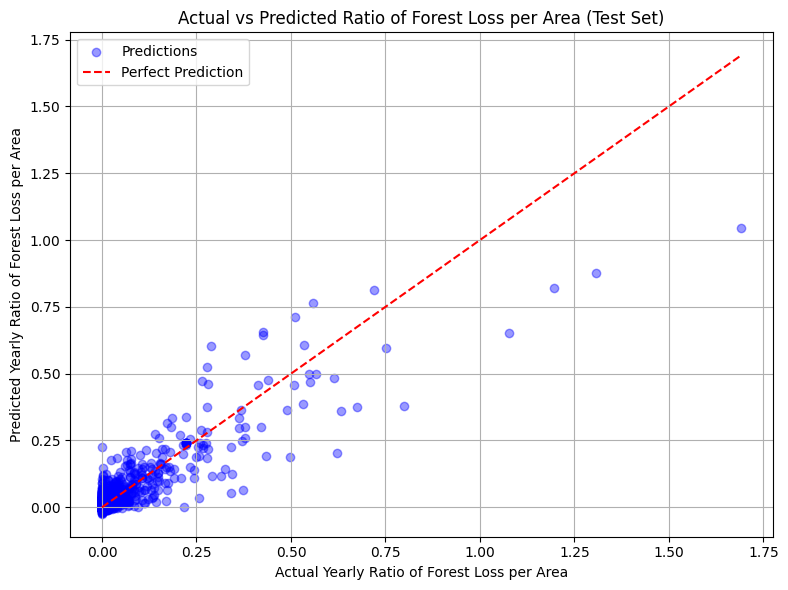

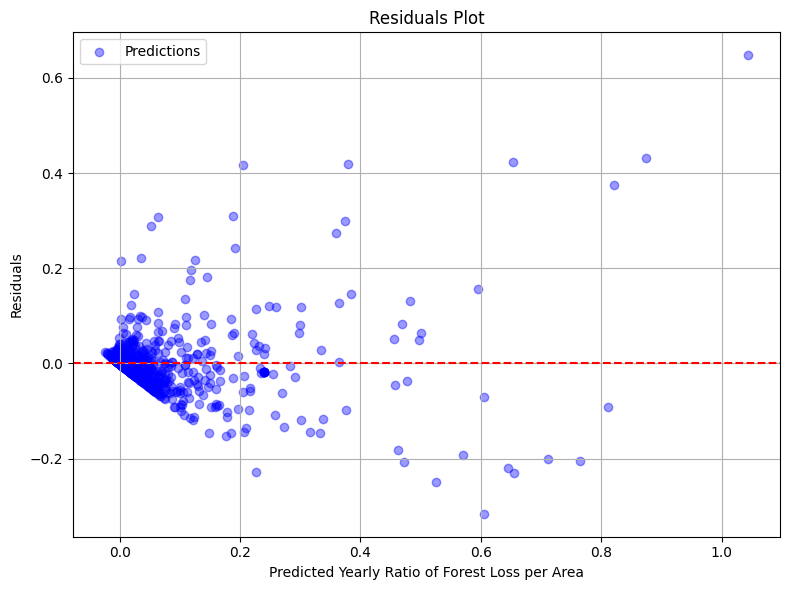

In [59]:
best_params = best_model["params"]

# Re-train on all available data
final_model = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Use your final trained model
final_model.fit(X_train, y_train)  # Re-train on training data since we will compare against the test set from last fold   
y_test_pred = final_model.predict(X_test)  # From your final fold
y_test_pred = np.expm1(y_test_pred)  # Inverse transform if you used log1p
y_true = y_test  # actual values
y_true = np.expm1(y_true)  # Inverse transform if you used log1p


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_true - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'XGBoost - mena absolut SHAP values (Top 10 Features)')

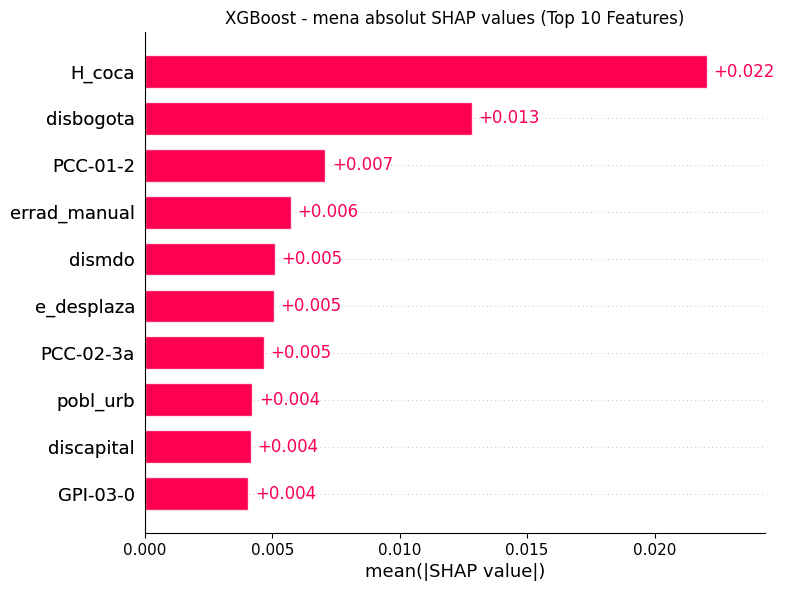

In [60]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("XGBoost - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


Text(0.5, 1.0, 'XGBoost - SHAP Beeswarm Plot (Top 10 Features)')

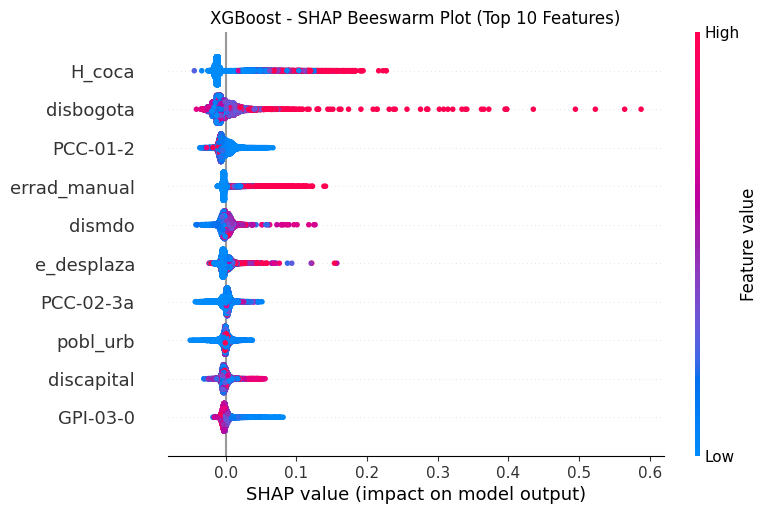

In [61]:
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("XGBoost - SHAP Beeswarm Plot (Top 10 Features)")
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”